No. Of Distinct Studies 

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Clinical Trial Analysis") \
    .master("local") \
    .getOrCreate()

# Load the data
file_path = "/FileStore/tables/clinicaltrial_2023.csv"
df = spark.read.option("header", "true").csv(file_path)
df.createOrReplaceTempView("clinical_trials")


In [0]:
clinicaltrial_2023_df = spark.read.option("header", "true").csv("/FileStore/tables/clinicaltrial_2023.csv")

In [0]:
pharma_df = spark.read.option("header", "true").csv("/FileStore/tables/pharma.csv")

In [0]:
clinicaltrial_2023_df.createOrReplaceTempView("clinicaltrial_2023")
pharma_df.createOrReplaceTempView("pharma")

In [0]:
from pyspark.sql.functions import col, split

# Defining the actual column name and replacing it with a proper name to avoid syntax issues
column_name = "`Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion`"

# Define the names of the new columns based on the expected structure
column_names = [
    "Id", "Study Title", "Acronym", "Status", "Conditions",
    "Interventions", "Sponsor", "Collaborators", "Enrollment",
    "Funder Type", "Type", "Study Design", "Start", "Completion"
]

# Split the single column into multiple columns based on the tab (\t) separator
for index, name in enumerate(column_names):
    clinicaltrial_2023_df = clinicaltrial_2023_df.withColumn(name, split(col(column_name), "\t").getItem(index))

# Drop the original column that contained all the data
clinicaltrial_2023_df = clinicaltrial_2023_df.drop(column_name)

# Show the schema to confirm the columns have been created correctly
clinicaltrial_2023_df.printSchema()

root
 |-- Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = tru

In [0]:
distinct_studies_rdd = clinicaltrial_2023_df.rdd.map(lambda row: row["Study Title"]).distinct().count()
print("Number of Distinct Studies:", distinct_studies_rdd)

Number of Distinct Studies: 469789


List all the types of studies with their frequencies

In [0]:
study_types_rdd = clinicaltrial_2023_df.rdd.map(lambda x: (x.Type, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)
print(study_types_rdd.collect())

[('INTERVENTIONAL', 230984), (None, 180459), ('OBSERVATIONAL', 71499), ('', 889), ('EXPANDED_ACCESS', 559)]


The top 5 conditions (from Conditions) with their frequencies.

In [0]:
top_conditions_rdd = clinicaltrial_2023_df.rdd \
    .map(lambda row: (row.Conditions, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda pair: pair[1], ascending=False) \
    .take(5)

for condition, count in top_conditions_rdd:
    print(condition, count)

None 41024
Healthy 6665
Breast Cancer 4138
Diabetes Mellitus 3333
Pain 2562


10 sponsors

In [0]:
pharma_companies_rdd = set(pharma_df.rdd.map(lambda x: x.Parent_Company).collect())
top_sponsors_rdd = clinicaltrial_2023_df.rdd.filter(lambda x: x.Sponsor not in pharma_companies_rdd).map(lambda x: (x.Sponsor, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False).take(10)
print(top_sponsors_rdd)

[(None, 95209), ('University Hospital', 8363), ('University of California', 4100), ('Assiut University', 2913), ('Cairo University', 2570), ('Assistance Publique - Hôpitaux de Paris', 2539), ('Mayo Clinic', 2328), ('National Cancer Institute (NCI)', 2325), ('M.D. Anderson Cancer Center', 2181), ('Massachusetts General Hospital', 1979)]


Plot no. of completed studies for each month in 2023

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, month, year
import matplotlib.pyplot as plt
import pandas as pd


In [0]:
spark = SparkSession.builder \
    .appName("Clinical Trials Completion Analysis") \
    .getOrCreate()


In [0]:
from pyspark.sql.functions import col
import calendar

# A dictionary to convert month numbers to month names, while maintaining a sortable index
month_index_name_map = {str(i).zfill(2): (i, calendar.month_name[i]) for i in range(1, 13)}

# Filter to ensure there is a date and it starts with '2023'
completed_studies_rdd = clinicaltrial_2023_df \
    .filter(col("Completion").isNotNull() & col("Completion").startswith("2023")) \
    .rdd \
    .map(lambda x: (x.Completion[:7], 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .map(lambda x: (month_index_name_map[x[0][5:]], x[1])) \
    .sortBy(lambda x: x[0][0]) \
    .map(lambda x: (x[0][1], x[1]))  # This step converts tuple indexes back to month names

# Collect and print results
print(completed_studies_rdd.collect())


[('January', 1294), ('February', 1046), ('March', 1471), ('April', 1170), ('May', 1287), ('June', 1789), ('July', 1375), ('August', 1346), ('September', 1432), ('October', 1313), ('November', 1150), ('December', 4666)]


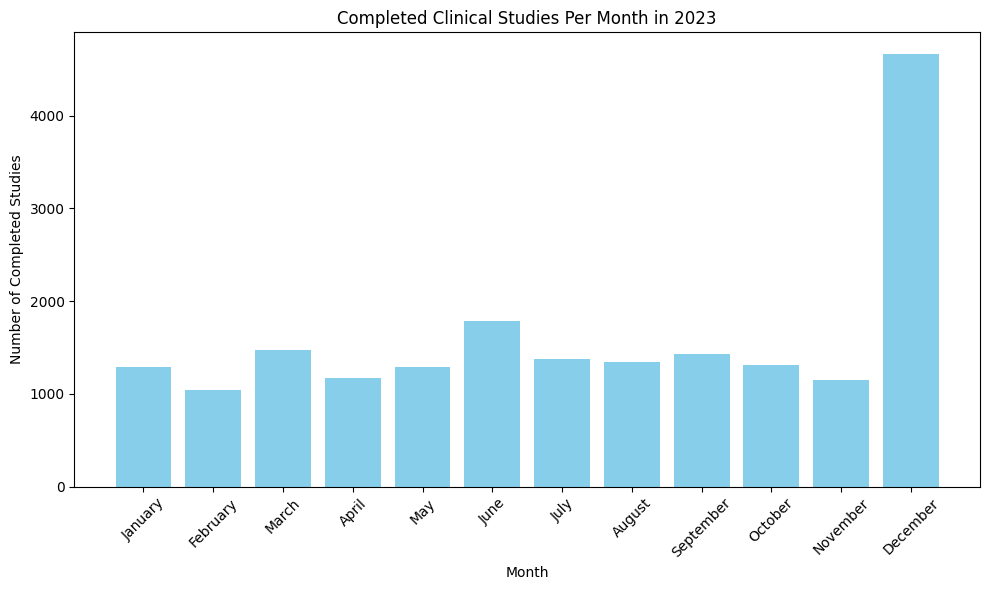

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import calendar

# Dictionary to convert month numbers to month names, maintaining a sortable index
month_index_name_map = {str(i).zfill(2): (i, calendar.month_name[i]) for i in range(1, 13)}

# Filter and transform data in the RDD
completed_studies_rdd = clinicaltrial_2023_df \
    .filter(col("Completion").isNotNull() & col("Completion").startswith("2023")) \
    .rdd \
    .map(lambda x: (x.Completion[:7], 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .map(lambda x: (month_index_name_map[x[0][5:]], x[1])) \
    .sortBy(lambda x: x[0][0]) \
    .map(lambda x: (x[0][1], x[1])) \
    .collect()  # Collecting data for visualization

# Unpacking the results for plotting
months, counts = zip(*completed_studies_rdd)

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(months, counts, color='skyblue')
plt.title('Completed Clinical Studies Per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.xticks(rotation=45)  # Rotate month names for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated month labels
plt.show()
